In [1]:
import pandas, csv, time
import tweepy
import webbrowser

consumer_key = 'urBfiZz4ztGR7pzLKCTpI3oML'
secret_key = 'OOPgRXDgpQhzneTrqcY63igbjkfdB2gqZ88ChGhj3kIo9VqKf2'
bearer_token = 'AAAAAAAAAAAAAAAAAAAAAJmHIwEAAAAAwR6Bwu%2BRRZmAQn9t%2Bao%2BlgFI5%2F4%3D7uQVJIHjuG1vPHZNfsdKJGpfGbWvLRCj50UFkA4TdF3iRRYtS1'
access_token = '1317128139261304832-43UyRfOPGcLWjS2M801BhqyANfXeNJ'
access_secret = '29FXOSp3GoAst8tIKgBZ52SOVTi7Ug7XHhDZMYRF5B5Kt'

callback_uri = 'oob'
#sign in to twitter using consumer key and secrete key
auth = tweepy.OAuthHandler(consumer_key, secret_key, callback_uri)
#grabs a url after successful authentication
redirect_url = auth.get_authorization_url()
webbrowser.open_new_tab(redirect_url)
print(redirect_url)

#click on url and grab pin number
#pin number will change every loggin 
user_pin_input = input("Enter Pin Number: ")

#now the auth object has access to your consumer and secret token:
auth.get_access_token(user_pin_input)
print(auth.access_token)
print()
print(auth.access_token_secret)

api = tweepy.API(auth, wait_on_rate_limit=True)
#now you have access to everything in the api. 
#see documentation

https://api.twitter.com/oauth/authorize?oauth_token=x1H5wQAAAAABI4eZAAABdkRBWYs
Enter Pin Number: 8294349
1317128139261304832-FLljxAQviuMVHQoiRpeFghc6VoDODQ

h7bZ20TVfLKTW19aDfnNcX3JAyHc2auYDgG7ByRJfKF5l


In [ ]:
#API.search(q[, geocode][, lang][, locale][, result_type][, count][, until][, since_id][, max_id][, include_entities])

In [2]:
def save_tweets(path,data,results):
    #helper function 
    #saves tweets to CSV in path 
    
    for status in results:
        try: #retweet
            data.append([status.id,
                        status.user.screen_name,
                        status.created_at,
                        status.geo,
                        status.place,
                        status.lang,
                        status.favorite_count,
                        status.retweet_count,
                        status.user.id,
                        status.user.description,
                        status.user.location,
                        status.user.followers_count,
                        status.user.created_at,
                        status.user.verified,
                        status.retweeted_status.full_text]) #list of lists
        except:
            data.append([status.id,
                        status.user.screen_name,
                        status.created_at,
                        status.geo,
                        status.place,
                        status.lang,
                        status.favorite_count,
                        status.retweet_count,
                        status.user.id,
                        status.user.description,
                        status.user.location,
                        status.user.followers_count,
                        status.user.created_at,
                        status.user.verified,
                        status.full_text])

    maxid=results[len(results)-1].id

    # writing to csv file  
    with open(path, 'w', encoding = 'utf-8', newline='') as outputfile:  
        # creating a csv writer object  
        csvwriter = csv.writer(outputfile)  

        # writing the data rows  
        csvwriter.writerows(data) 

In [7]:
def get_n_clean_tweets(search_type ="mixed"):
    #main function: does an extended search for terms in query_list and saves csv to desktop with current timestamp
    import datetime, time, csv
    import pandas as pd
    query_list = ["nuclear power", 'nuclear waste', 'nuclear radiation', 'nuclear reactor', 'radiation pollution', 'nuclear accident', 'nuke energy', 'nuke power', "nuclear energy"]
    filename = 'nuclear_'+(datetime.datetime.now().strftime("%Y-%m-%d-%H"))+'.csv' #<-- file name  
    for query in query_list:
        #Add time your file was created to discriminate date/time after running the crontab file
        start = time.perf_counter()
        with open (filename, 'a+', encoding = "utf-16", newline='') as csvFile:
            csvWriter = csv.writer(csvFile)
            #using tweepy Cursor, write directly to csv. "popular", "mixed", "recent"
            for tweet in tweepy.Cursor(api.search, q=query, result_type=search_type, lang = 'en', tweet_mode='extended').items():#writing a csv file
                try:
                    text = tweet.retweeted_status.full_text
                    
                except:
                    text = tweet.full_text
                    
                csvWriter.writerow([datetime.datetime.now().strftime("%Y-%m-%d  %H:%M"), 
                                    tweet.id, 
                                    text, 
                                    tweet.created_at, 
                                    tweet.favorite_count, 
                                    tweet.retweet_count,
                                    tweet.place.name if tweet.place else None, 
                                    tweet.coordinates, 
                                    tweet._json["user"]["id"], 
                                    tweet._json["user"]["screen_name"], 
                                    tweet._json["user"]["description"],
                                    tweet._json["user"]["followers_count"], 
                                    tweet._json["user"]["verified"], 
                                    tweet._json["user"]["location"]])

            csvFile.close()

        print(time.perf_counter() - start, "seconds for '", query, "'")
        
    ### when that's done getting all the tweets 
    
    #clean with pandas
    df = pd.read_csv(filename, encoding='utf-16', header=None)
    df.rename(columns = {0:'time_retrieved',
                         1:'status_id',
                         2:'text',
                         3:'created_at',
                         4:'favorite_count',
                         5:'retweet_count',
                         6:'place',
                         7:'coordinates',
                         8:'user_id',
                         9:'screen_name',
                         10:'user_description',
                         11:'user_follower_count',
                         12:'verified',
                         13:'user_location'}, inplace = True) 
    #drop duplicates
    df.drop_duplicates(subset=['status_id'], inplace=True)
    
    #set index
    df.set_index('status_id', inplace=True)

    #drop tweets that have no location information at all
    df.dropna(how='any', subset=['text','user_location'], inplace=True)

    ### Parse location : 
    #create location dictionaries 
    import csv
    city_dict = dict() #this dicts maps user location input to a city's name
    state_dict = dict()
    country_dict = dict()
    with open('location_dict.csv', 'r', encoding='utf-8', newline='') as File:  
        reader = csv.reader(File)
        for row in reader: 
            city_dict[row[0].strip().lower()] = row[1].strip().lower() #make everything lower case for the dictionary key
            state_dict[row[0].strip().lower()] = row[2].strip().lower()
            country_dict[row[0].strip().lower()] = 'USA'
            

    #iterate through the rows of the tweet bank and clean up user input
    for ind, row in df.iterrows():
        #loop down the rows of the dataframe 
        #if user location data isn't already in the dictionary, try to to clean up user input a little
        if row['user_location'] not in country_dict.keys():
            try:
                #clean user-reported location a little 
                location = [token.strip().lower().replace('.','') for token in row['user_location'].split(',')]
                for token in location:
                    try:
                        city_dict[row['user_location']] = city_dict[token] #these dicts take user input as key and output city/state/country
                        state_dict[row['user_location']] = state_dict[token]
                        country_dict[row['user_location']] = country_dict[token]
                        break
                    except: #if any of those dictionary indexes fail, it means that the token isn't in the locaiton.csv
                        None
            except:
                None

    # parse location with dictionaries
    df['City'] = df['user_location'].map(city_dict)
    df['State'] = df['user_location'].map(state_dict)
    df['Country'] = df['user_location'].map(country_dict)
    
    #drop all tweets that couldn't be confirmed to be in USA
    df.dropna(how='any', subset=['Country'], inplace=True) 
    
    #save dataframe in UTF-8 by default
    df.to_csv(filename)
    print("Done!")
    

In [9]:
get_n_clean_tweets("recent") #last time this took 2.5 hours for mixed

5492.2315296000015 seconds for ' nuclear power '
925.6094538000034 seconds for ' nuclear waste '
875.7276210999989 seconds for ' nuclear radiation '
40.73538579999877 seconds for ' nuclear reactor '
813.6927276999922 seconds for ' radiation pollution '
8.70773399999598 seconds for ' nuclear accident '
6.664801099992474 seconds for ' nuke energy '
11.705570100006298 seconds for ' nuke power '
4515.80470220001 seconds for ' nuclear energy '
Done!


### Temp: Fix Location data

In [23]:
### Parse location : 
filepath = "Total_12-2-20.csv"

#create location dictionaries 
import csv
city_dict = dict() #this dicts maps user location input to a city's name
state_dict = dict()
country_dict = dict()
with open('location_dict.csv', 'r', encoding='utf-8', newline='') as File:  
    reader = csv.reader(File)
    for row in reader: 
        city_dict[row[0].strip().lower()] = row[1].strip().lower() #make everything lower case for the dictionary key
        state_dict[row[0].strip().lower()] = row[2].strip().lower()
        country_dict[row[0].strip().lower()] = 'USA'

#create other country dictionary 
not_usa_dict = dict()
with open('other_countries_dict.csv', 'r', encoding='utf-8', newline='') as File:  
    reader = csv.reader(File)
    for row in reader: 
        not_usa_dict[row[0].strip().lower()] = True
        
        
data_type_dict = {"status_id":str ,"user_id":str}
df = pd.read_csv(filepath, encoding='utf-8', index_col =0, dtype = data_type_dict, engine='python')
#iterate through the rows of the tweet bank and clean up user input
for ind, row in df.iterrows():
    #loop down the rows of the dataframe 
    #if user location data isn't already in the dictionary and isn't proven to be another country
    #then try to to clean up user input a little
    if row['user_location'] not in country_dict and row['user_location'] not in not_usa_dict:
        try:
            #clean user-reported location a little 
            location = [token.strip().lower().replace('.','') for token in row['user_location'].split(',')]
            for token in location:
                try:
                    city_dict[row['user_location']] = city_dict[token] #these dicts take user input as key and output city/state/country
                    state_dict[row['user_location']] = state_dict[token]
                    country_dict[row['user_location']] = country_dict[token]
                    break
                except: #if any of those dictionary indexes fail, it means that the token isn't in the locaiton.csv
                    None
        except:
            None

# parse location with dictionaries
df.user_location = df.user_location.str.lower()
df['City'] = df['user_location'].map(city_dict)
df['State'] = df['user_location'].map(state_dict)
df['Country'] = df['user_location'].map(country_dict)

#drop all tweets that couldn't be confirmed to be in USA
df.dropna(how='any', subset=['Country'], inplace=True) 

#save dataframe in UTF-8 by default
df.to_csv("new_Total_12-2-20.csv")

print(df.shape)

(27513, 16)


### Combine CSV files

In [44]:
import pandas as pd
data_type_dict = {"status_id":str ,"user_id":str}
df1 = pd.read_csv('Total_12_2_20.csv', encoding='utf-8', index_col =0, dtype = data_type_dict, engine='python')
df2 = pd.read_csv('new_11-13-20.csv', encoding='utf-8', index_col =0, dtype = data_type_dict, engine='python')
df3 = pd.read_csv('new_11-21-20.csv', encoding='utf-8', index_col =0, dtype = data_type_dict, engine='python')
frames = [df1, df2, df3]
result = pd.concat(frames)
result = result[~result.index.duplicated(keep='first')] #remove duplicate status_id's
result.to_csv("new_old_12-2-20.csv")
print(df1.shape, df2.shape, df3.shape, "=>", result.shape)

(26098, 16) (7315, 16) (1760, 16) => (28659, 16)


In [45]:
len(result.screen_name.unique())

12060

### playing around:

In [24]:
data_type_dict = {"status_id":str ,"user_id":str}
import pandas as pd
df1 = pd.read_csv('new_Total_12-2-20.csv', encoding='utf-8', index_col =0, dtype = data_type_dict, engine='python')
df1.shape

(27513, 16)

In [25]:
len(df1.screen_name.unique())

11376

In [28]:
df1.State.value_counts().median()

270.5

In [29]:
df1.State.value_counts()

md    4249
ca    3345
ny    3113
tx    1364
fl    1249
il    1052
va     958
wa     922
pa     825
nc     818
id     660
ma     656
co     516
ga     485
or     452
oh     410
mi     376
nj     350
wi     339
mo     335
mn     327
tn     310
az     295
nm     293
sc     291
ut     250
nv     250
in     202
vt     145
ne     132
ct     130
al     124
ok     123
la     109
ia      97
ky      89
nh      79
ks      70
ar      64
ri      60
hi      58
me      53
mt      47
wv      40
ms      38
wy      26
de      22
ak      21
sd      16
nd      15
Name: State, dtype: int64

### Refine Tweets by topic. Delete tweets about the weather

In [35]:
def filter_topics(filename):
    import pandas as pd
    data_type_dict = {"status_id":str ,"user_id":str}
    df = pd.read_csv(filename, encoding='utf-8', index_col =0, dtype = data_type_dict, engine='python')
    print(df.shape, "original size of df")
    index_names = df[ df['screen_name'] == "WeatherLampPost" ].index #weather channel 
    df.drop(index_names, inplace = True) 
    #filter out tweets with these words 
    df = df[~df['text'].str.contains('NuclearPowrTrio')] #rock band 
    df = df[~df['text'].str.contains('gordon')] #DOE resigning
    df = df[~df['text'].str.contains('resign')] #DOE resigning
    df = df[~df['text'].str.contains('Simpson')] #the simpson cartoon
    df = df[~df['text'].str.contains('simpson')] #the simpson cartoon
    df = df[~df['text'].str.contains('Springfield')] #the simpson cartoon

    print(df.shape, "after deleting tweets about irrelevant topics")
    df.to_csv(filename)

In [36]:
filter_topics("final_cleaned_nuclear_12-1-20.csv")

(6843, 16) original size of df
(6813, 16) after deleting tweets about irrelevant topics


### Word Clouds

In [3]:
def make_cloud(filepath, add_stops=[]):
    from wordcloud import WordCloud, STOPWORDS 
    import matplotlib.pyplot as plt 
    import os, csv
    
    comment_words = ''
    stopwords = set(STOPWORDS) 
    for word in add_stops:
        stopwords.add(str(word).lower())
        
        
    #iterates over a directory to update each file of recent tweets 
    with open(filepath, 'r', encoding='utf-8', newline='') as File:  
        reader = csv.reader(File)
        for row in reader: #each row is a new tweet 
            tokens = str(row[2]).lower().split()
            comment_words += " ".join(tokens)+" "

        File.close()
            
    wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 
    
    # plot the WordCloud image                        
    plt.figure(figsize = (8, 8), facecolor = None) 
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 

    plt.show() 


In [ ]:
### split labeled data into three different csv files 
def split_labeled_data(filename):
    import pandas as pd 
    df = pd.read_csv(filename, encoding='utf-8', index_col =0, engine='python')
    df_pos = df[ df['label'] == "positive" ]
    df_neu = df[ df['label'] == "neutral" ]
    df_neg = df[ df['label'] == "negative" ]
    df_pos.to_csv("pos_"+filename)
    df_neu.to_csv("neu_"+filename)
    df_neg.to_csv("neg_"+filename)

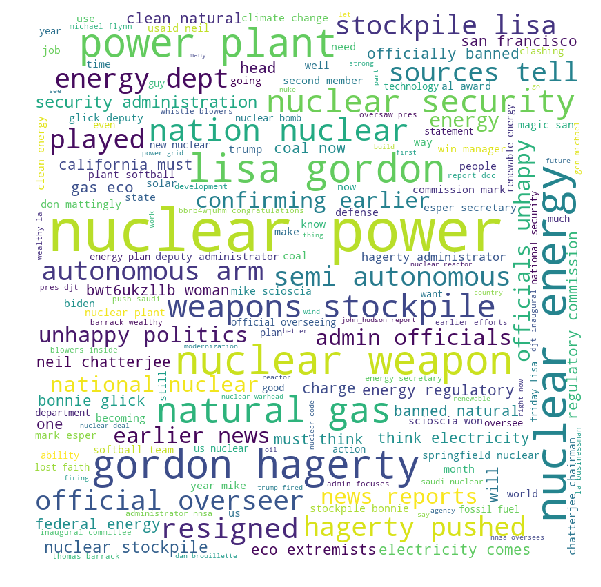

In [4]:
additional_stop_words = ['https', 'http', 'amp', 'co']

In [ ]:
make_cloud("C:/Users/sbgas/OneDrive/Desktop/final_11-13-20.csv", additional_stop_words)

### Plot the three categories over time 

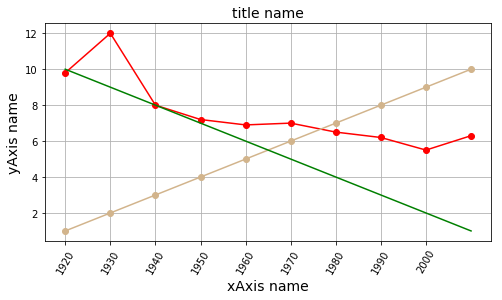

In [79]:
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np 

Data = {'Year': [1920,1930,1940,1950,1960,1970,1980,1990,2000,2010],
        'Unemployment_Rate': [9.8,12,8,7.2,6.9,7,6.5,6.2,5.5,6.3], 
        'Fake_employment1' : [1,2,3,4,5,6,7,8,9,10],
        'Fake_employment2' : [10,9,8,7,6,5,4,3,2,1]
       }
  
df = pd.DataFrame(Data,columns=['Year','Unemployment_Rate','Fake_employment1','Fake_employment2'])

#the size must be the first parameter of the plot you set
plt.figure(figsize=(8,4))

#plt.ylim(bottom=0, top=max(df['Unemployment_Rate']))
#plt.xlim(left=min(df['Year']), right=max(df['Year']))

plt.xticks(np.arange(min(df['Year']), max(df['Year']), 10), rotation=60)

plt.plot(df['Year'],df['Unemployment_Rate'], color='red', marker='o')
plt.plot(df['Year'],df['Fake_employment1'], color='tan', marker='o')
plt.plot(df['Year'],df['Fake_employment2'], color='green', marker=None)
plt.title('title name', fontsize=14)
plt.xlabel('xAxis name', fontsize=14)
plt.ylabel('yAxis name', fontsize=14)
plt.grid(True)
plt.show()

## Plot state map of the US 

In [4]:
import geopandas as gpd
from shapely.geometry import Point, Polygon
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

In [69]:
usa = gpd.read_file('s_11au16/s_11au16.shp')
usa.drop(usa[usa['STATE']== 'AS'].index, inplace=True) #American Samoa
usa.drop(usa[usa['STATE']== 'PR'].index, inplace=True) #Puerto Rico
usa.drop(usa[usa['STATE']== 'VI'].index, inplace=True) #Virgin Islands
usa.drop(usa[usa['STATE']== 'GU'].index, inplace=True) #Guam
usa.drop(usa[usa['STATE']== 'MP'].index, inplace=True) #Northern Marianas
usa.drop(usa[usa['STATE']== 'DC'].index, inplace=True) #DC as a state
usa.drop(56, inplace=True) #Maryland had a duplicate record...
usa.shape

(50, 6)

In [74]:
usa.head()

,STATE,NAME,FIPS,LON,LAT,geometry
0,AK,Alaska,02,-152.24098,64.24019,(POLYGON ((-19938160.63891365 6641378.90483112...
1,AL,Alabama,01,-86.82676,32.79354,(POLYGON ((-9808372.291957667 3515346.14244236...
2,AR,Arkansas,05,-92.43920,34.89977,POLYGON ((-10200189.80561045 4344114.253693356...
4,AZ,Arizona,04,-111.66457,34.29323,"POLYGON ((-12299790.5173457 4413891.283886771,..."
5,CA,California,06,-119.60818,37.24537,(POLYGON ((-13183144.61454085 3845606.20799011...


In [90]:
a= [0.5]*12
b = [0]*25
c = [-0.5]*13
fake_data=a+b+c
len(fake_data)

50

In [91]:
#in the real thing, you'd usa.join "on" the column 'NAME'
usa['labels'] = fake_data
usa.head()

,STATE,NAME,FIPS,LON,LAT,geometry,labels
0,AK,Alaska,02,-152.24098,64.24019,(POLYGON ((-179.1075443916637 51.3012055020556...,0.5
1,AL,Alabama,01,-86.82676,32.79354,(POLYGON ((-88.11010742197489 30.2589111330007...,0.5
2,AR,Arkansas,05,-92.43920,34.89977,POLYGON ((-91.62986403299804 36.49921215999979...,0.5
4,AZ,Arizona,04,-111.66457,34.29323,POLYGON ((-110.4908981320001 37.00361251799955...,0.5
5,CA,California,06,-119.60818,37.24537,"(POLYGON ((-118.426203 32.7997249999992, -118....",0.5


^ These labels are going to be the balance of users within a state. i.e. if a user tweets multiple times, their tweets vote for their label. then it's the sum of labels (-1,0,1) divided by the number of labels in that state. So you'll get a percent positive or negative for the state. This is the Marginal sentiment. i.e. a 0.05 value for a state means a state is 5% pro-nuclear. 

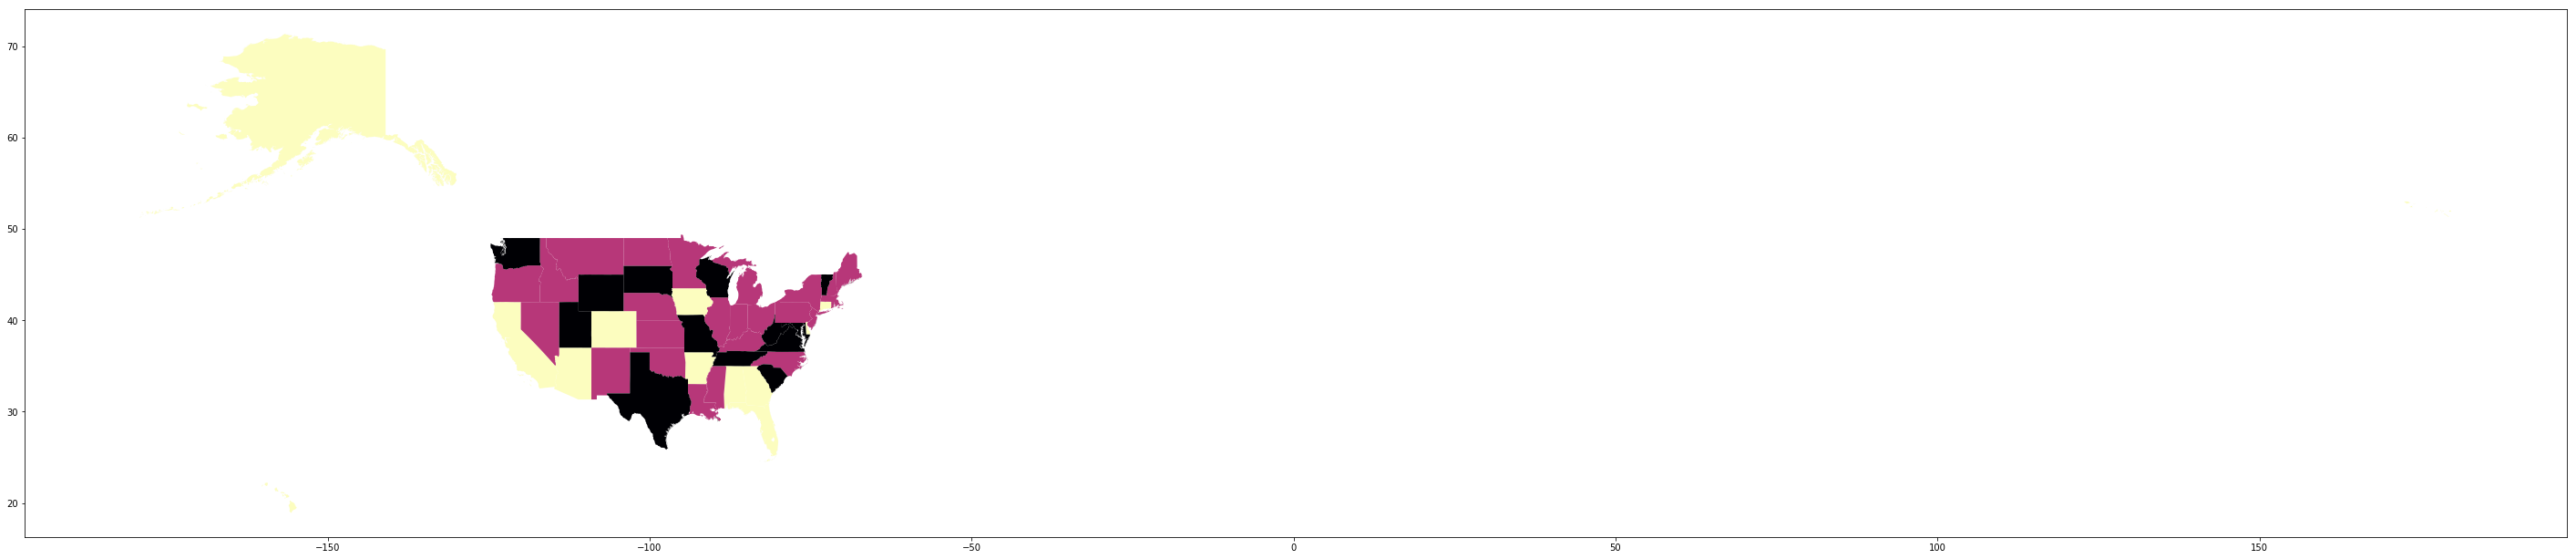

In [92]:
usa.plot(column='labels', cmap='magma', figsize=(50,50))

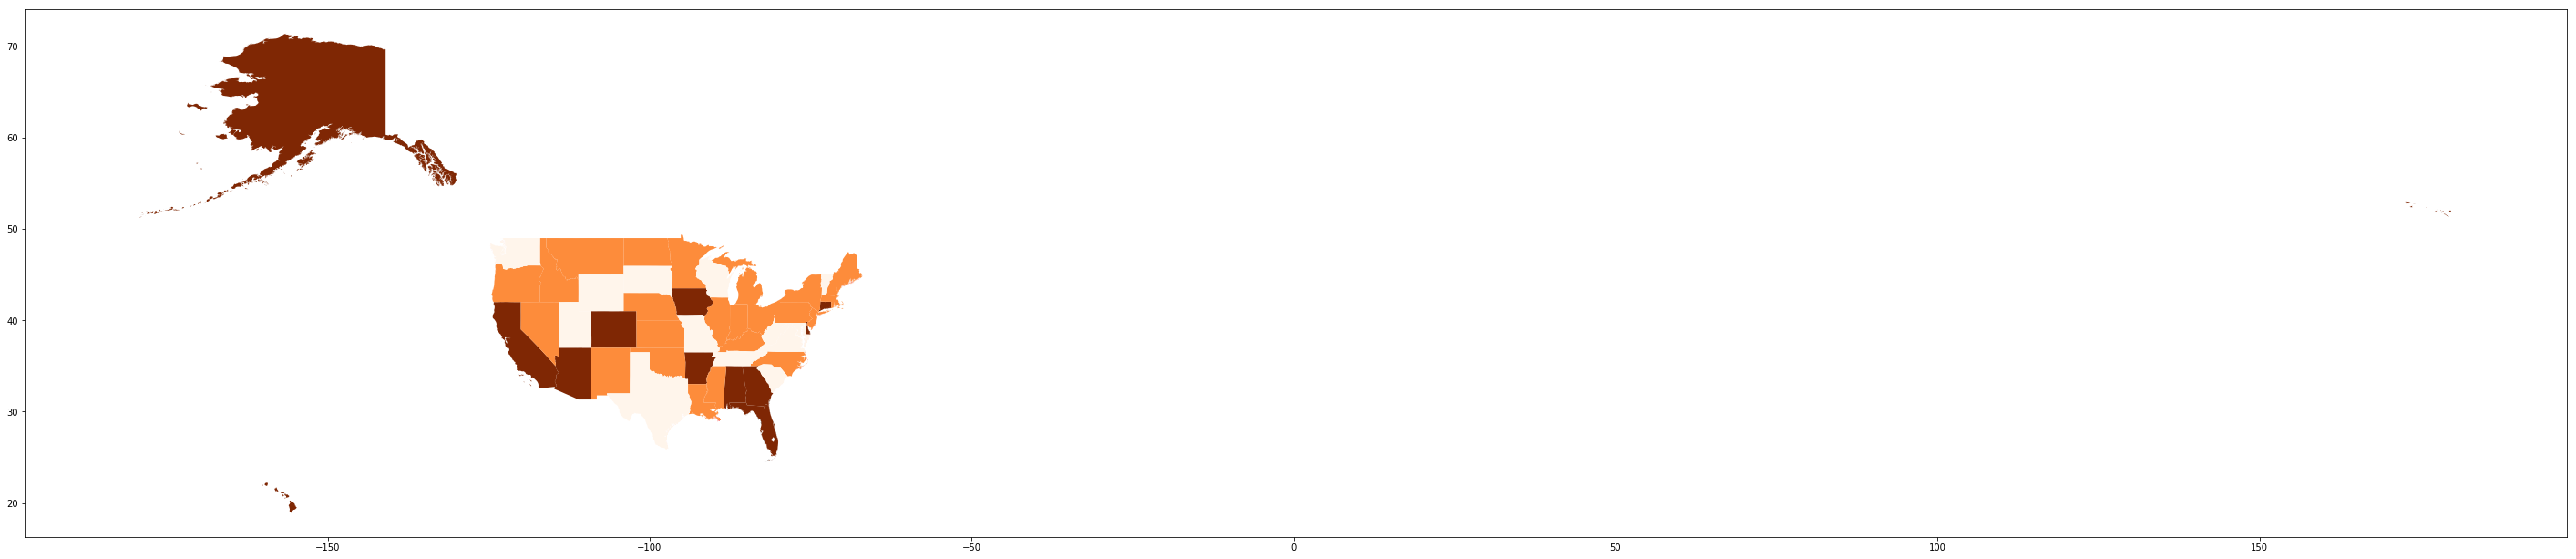

In [93]:
"""viridis, plasma, inferno, magma, cividis
Greys, Purples, Blues, Greens, Oranges, Reds
YlOrBr, OrRd, PuRd, RdPu, BuPu, GnBu, PuBu, YlGnBu, PuBuGn, BuGn, YlGn
PiYg, PRGn, BrBG, PuOr, RdGy, RdBu, RdYlBu, Spectral, coolwarm, bwr, seismic
twilight, twilight_shifted, hsv
Pastel1, Pastel2, PAired, Accent, Dark2, Set1, Set2, Set3, tab10, tab20, tab20b, tab20c"""
c_map = 'Oranges'
usa.plot(column='labels', cmap=c_map, figsize=(50,50))

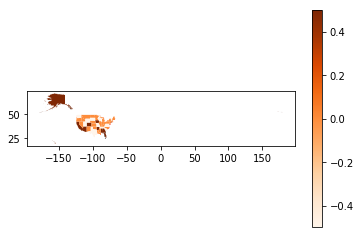

In [94]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1)
usa.plot(column='labels', cmap=c_map, figsize=(50,50), ax=ax, legend=True)

### Save Map to desktop

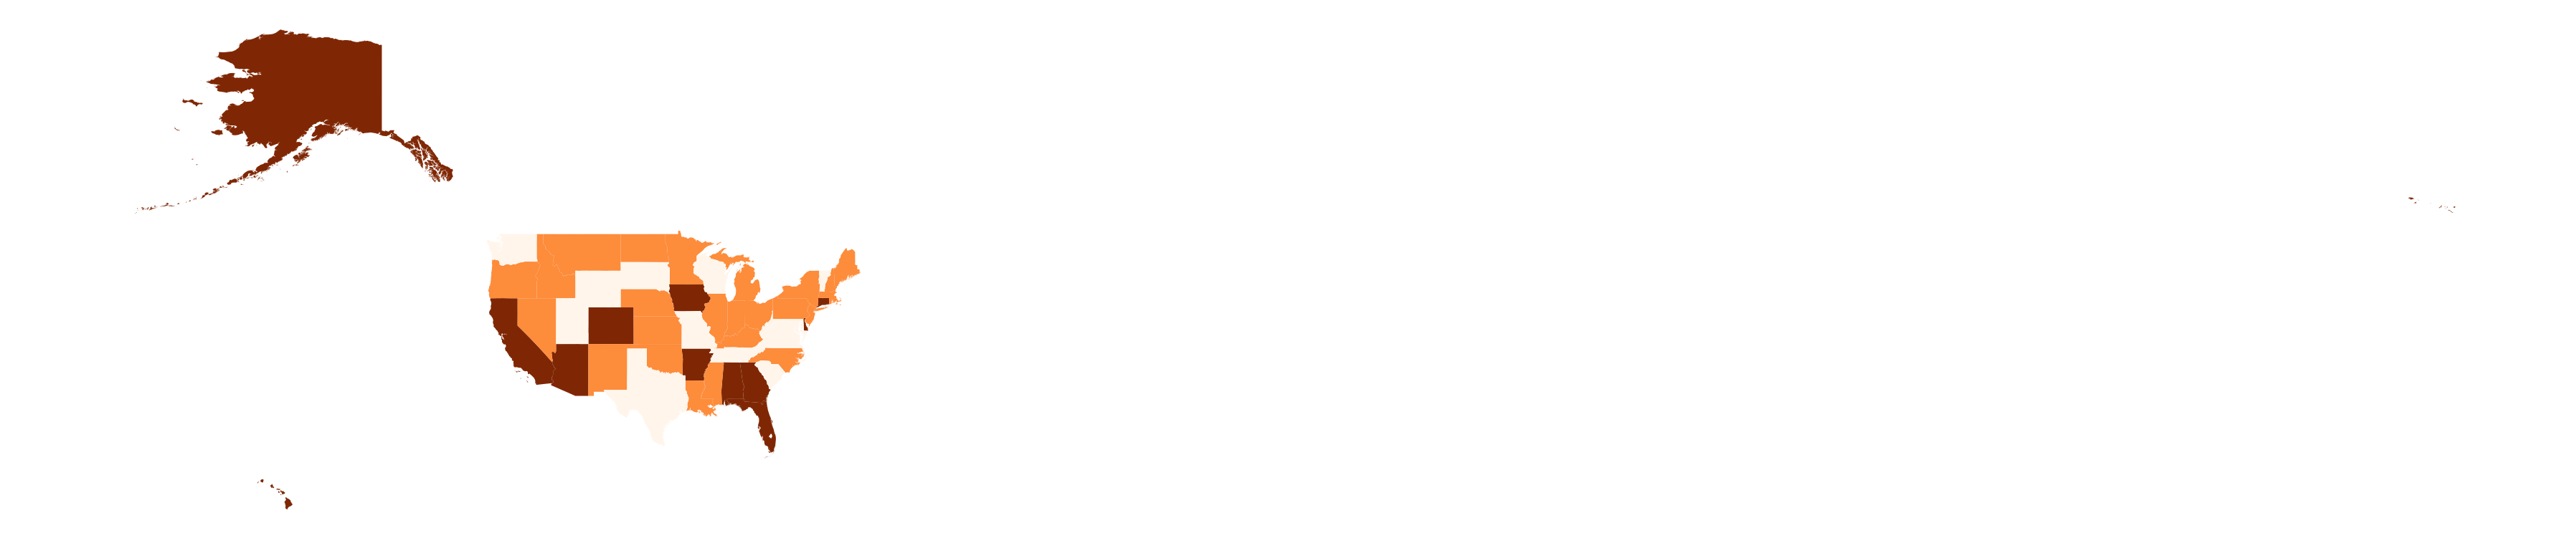

In [96]:
#saves without legend. If you want a screenshot of the legend, save a second file. 
us_map = usa.plot(column='labels', cmap=c_map, figsize=(50,50))
us_map.axis('off')
fig = us_map.get_figure()
fig.tight_layout()
fig.savefig('nuclear_energy_opinion_map.png', dpi=192)

### Make Bar chart for states 

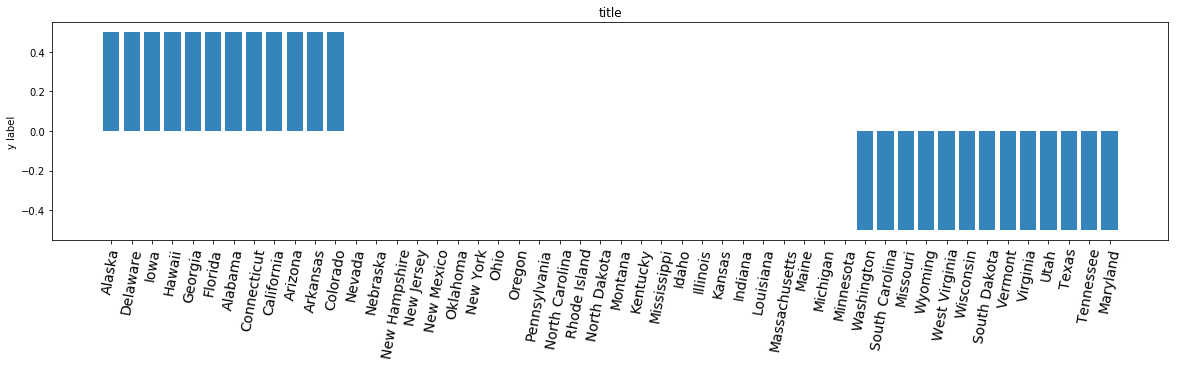

In [150]:
import numpy as np 

y_pos = np.arange(len(usa['NAME']))# [0,1,2,3,...,49]
plt.figure(figsize=(20,4))
plt.bar(y_pos, usa.sort_values(['labels'], ascending=False)['labels'], width=0.8, align='center', alpha=0.9)
plt.xticks(y_pos, usa.sort_values(['labels'], ascending=False)['NAME'], rotation=80, fontsize=14)
plt.ylabel('y label')
plt.title('title')

plt.show()

### Analyze users: not finished!!

In [ ]:
import pandas as pd 
filename = '' #labeled tweets 
labeled_df = pd.read_csv(filename, encoding='utf-8', index_col =0, engine='python')

#average tweet count
labeled_df['favorite_count'].apply(avg)
#average rewteet count
labeled_df['retweet_count'].apply(avg)
#most common city location
#average follow count
labeled_df.drop_duplicates(subset=['screen_name'])['user_follower_count'].apply(avg)
#%verified 
labeled_df.drop_duplicates(subset=['screen_name'])['verified'].value_counts(normalize=True) * 100
#% that have keyword like "organization" in their desc

for label in [-1,0,1]:
    df_temp = labeled_df[ labeled_df['label'] == label ]
    #average tweet like count
    df_temp['favorite_count'].apply(avg)
    #average rewteet count
    df_temp['retweet_count'].apply(avg)
    #remove duplicate users
    df_temp.drop_duplicates(subset=['screen_name'], inplace=True)
    #most common city location
    # get top 10 most frequent names
    df_temp['City'].value_counts()[:10].index.tolist()
    #average follower count
    df_temp['user_follower_count'].apply(avg)
    #%verified 
    df_temp['verified'].value_counts(normalize=True) * 100
    #% that have keyword like "organization", "research", "engineer" in their desc
    
    #make word cloud out of description
    ?Save in separate files? 

### get 3000 tweets that were in that twint project

In [163]:
def get_specific_tweet(filename):
    #main function: does an extended search for terms in query_list and saves csv to desktop with current timestamp
    import datetime, time, csv
    import pandas as pd
    
    df = pd.read_csv(filename)

    
    #Add time your file was created to discriminate date/time after running the crontab file
    start = time.perf_counter()
    filename = 'nuclear_'+filename #new file
    with open (filename, 'a+', encoding = "utf-16", newline='') as csvFile:
        csvWriter = csv.writer(csvFile)
        for index, row in df.iterrows():
            try:
                tweet = api.get_status(row['id'],tweet_mode='extended')
                try:
                    text = tweet.retweeted_status.full_text

                except:
                    text = tweet.full_text

                csvWriter.writerow([datetime.datetime.now().strftime("%Y-%m-%d  %H:%M"), 
                                    tweet.id, 
                                    text, 
                                    tweet.created_at, 
                                    tweet.favorite_count, 
                                    tweet.retweet_count,
                                    tweet.place.name if tweet.place else None, 
                                    tweet.coordinates, 
                                    tweet._json["user"]["id"], 
                                    tweet._json["user"]["screen_name"], 
                                    tweet._json["user"]["description"],
                                    tweet._json["user"]["followers_count"], 
                                    tweet._json["user"]["verified"], 
                                    tweet._json["user"]["location"]])
            except:
                print("ID not valid:", row['id'])

        csvFile.close()

    print(time.perf_counter() - start, "seconds")
        
    ### when that's done getting all the tweets 
    
    #clean with pandas
    df = pd.read_csv(filename, encoding='utf-16', header=None)
    df.rename(columns = {0:'time_retrieved',
                         1:'status_id',
                         2:'text',
                         3:'created_at',
                         4:'favorite_count',
                         5:'retweet_count',
                         6:'place',
                         7:'coordinates',
                         8:'user_id',
                         9:'screen_name',
                         10:'user_description',
                         11:'user_follower_count',
                         12:'verified',
                         13:'user_location'}, inplace = True) 
    #drop duplicates
    df.drop_duplicates(subset=['status_id'], inplace=True)
    
    #set index
    df.set_index('status_id', inplace=True)

    #drop tweets that have no location information at all
    df.dropna(how='any', subset=['text','user_location'], inplace=True)

    #save changes
    df.to_csv("cleaned_"+filename)

In [164]:
get_specific_tweet("twint_tweets.csv")

ID not valid: 1271852566574497792
ID not valid: 1271849788456071169
ID not valid: 1271846742405730311
ID not valid: 1271841495088168960
ID not valid: 1271840480557502466
ID not valid: 1271834704485003265
ID not valid: 1271830394254397441
ID not valid: 1271824968607690752
ID not valid: 1271819643745980417
ID not valid: 1271804816801640449
ID not valid: 1271804104013164545
ID not valid: 1271799665021902850
ID not valid: 1271795378212548614
ID not valid: 1271790453432688641
ID not valid: 1271788039921156102
ID not valid: 1271787622063464454
ID not valid: 1271744532581883904
ID not valid: 1271741642958082048
ID not valid: 1271737727025807361
ID not valid: 1271736948512698368
ID not valid: 1271736930074595333
ID not valid: 1271735594956316676
ID not valid: 1271727230247469056
ID not valid: 1271723114158854144
ID not valid: 1271692193317691410
ID not valid: 1271664614464462848
ID not valid: 1271662340899917824
ID not valid: 1271662112201302016
ID not valid: 1271652145704710144
ID not valid: 

ID not valid: 1270103501394391042
ID not valid: 1270101893218525184
ID not valid: 1270071457767440385
ID not valid: 1270070978186534914
ID not valid: 1270067832450093057
ID not valid: 1270064445184712704
ID not valid: 1270058583674290182
ID not valid: 1270045745316425729
ID not valid: 1270043742368608256
ID not valid: 1270039349149806592
ID not valid: 1270038071707340801
ID not valid: 1270034996833726465
ID not valid: 1270022316378992643
ID not valid: 1270019517008220162
ID not valid: 1270013451495243776
ID not valid: 1270010646139228165
ID not valid: 1270006912961187840
ID not valid: 1270005519101689856
ID not valid: 1270004691494211586
ID not valid: 1270000733148966913
ID not valid: 1270000405297020928
ID not valid: 1269998846744170496
ID not valid: 1269981837201256448
ID not valid: 1269980053254873096
ID not valid: 1269978189654298626
ID not valid: 1269977299681783816
ID not valid: 1269970170686177282
ID not valid: 1269946483513663488
ID not valid: 1269945163171971073
ID not valid: 

ID not valid: 1266945581127282688
ID not valid: 1266897202825383937
ID not valid: 1266879175362633730
ID not valid: 1266855211127234563
ID not valid: 1266853218220273665
ID not valid: 1266842346332860416
ID not valid: 1266832508970098688
ID not valid: 1266819616686432258
ID not valid: 1266796139636043783
ID not valid: 1266795900346695680
ID not valid: 1266792594836725761
ID not valid: 1266737895739723778
ID not valid: 1270394373520470016
5237.796493600006 seconds


### parse their locations

In [28]:
parse_location('nuclear_200_twinter_tweets.csv')

In [29]:
filter_topics('final_nuclear_200_final_11-15-20.csv')
filter_topics('final_nuclear_200_twinter_tweets.csv')

(11364, 16) after deleting WeatherLampPost
(11342, 16) after deleting tweets about gordon resingation and power trio
(4411, 16) after deleting WeatherLampPost
(4406, 16) after deleting tweets about gordon resingation and power trio


In [24]:
get_200("final_11-15-20.csv")

Couldnt find StormcrowYaBoi
Couldnt find Ethan_Mizzi
Couldnt find thmakled
Couldnt find ElvisAbellard
Couldnt find BoriLoco91
Couldnt find CNJ_Joker
Couldnt find Uncle__Ty
Couldnt find TomHoefWrites
Couldnt find vickiemjb
Couldnt find chillylukechill
Couldnt find CynthiaExelon
Couldnt find block_loves
Couldnt find Franky_Banky
Couldnt find MarkWinegardner
Couldnt find NewsSNC
Couldnt find PayamAlipour2
Couldnt find kaldordraigo2
Couldnt find TheEmCTaylor
Couldnt find JamieDevlin1633
Couldnt find silent_no_more5
Couldnt find HermitComics
4236.491481700001 seconds


C:\Users\sbgas\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3191: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  if (yield from self.run_code(code, result)):


### get the last 200 tweets from all users in a tweet bank 

In [8]:
def get_200(filename):
    #reads a csv into a dataframe, and then gets the last 200 tweets from names in the column 'screen_name'
    import datetime, time, csv
    import pandas as pd

    df = pd.read_csv(filename)
    df.drop_duplicates(subset=['screen_name'], inplace=True)
    
    start = time.perf_counter()
    outputfilename = '200_'+filename
    with open (outputfilename, 'a+', encoding = "utf-16", newline='') as csvFile:
        csvWriter = csv.writer(csvFile)
        for index, row in df.iterrows(): #for every user name in the input file 
            #get max tweets from user's timeline
            try:
                for tweet in api.user_timeline(screen_name=row['screen_name'], count=200, tweet_mode="extended"):
                    try:
                        text = tweet.retweeted_status.full_text

                    except:
                        text = tweet.full_text

                    csvWriter.writerow([datetime.datetime.now().strftime("%Y-%m-%d  %H:%M"), 
                                        tweet.id, 
                                        text, 
                                        tweet.created_at, 
                                        tweet.favorite_count, 
                                        tweet.retweet_count,
                                        tweet.place.name if tweet.place else None, 
                                        tweet.coordinates, 
                                        tweet._json["user"]["id"], 
                                        tweet._json["user"]["screen_name"], 
                                        tweet._json["user"]["description"],
                                        tweet._json["user"]["followers_count"], 
                                        tweet._json["user"]["verified"], 
                                        tweet._json["user"]["location"]])
            except:
                print('Couldnt find', row['screen_name'])

        csvFile.close()

    print(time.perf_counter() - start, "seconds")
        
    ### when that's done getting all the tweets 
    
    #clean with pandas
    df = pd.read_csv(outputfilename, encoding='utf-16', header=None)
    df.rename(columns = {0:'time_retrieved',
                         1:'status_id',
                         2:'text',
                         3:'created_at',
                         4:'favorite_count',
                         5:'retweet_count',
                         6:'place',
                         7:'coordinates',
                         8:'user_id',
                         9:'screen_name',
                         10:'user_description',
                         11:'user_follower_count',
                         12:'verified',
                         13:'user_location'}, inplace = True) 
    #drop duplicates
    df.drop_duplicates(subset=['status_id'], inplace=True)
    
    #set index
    df.set_index('status_id', inplace=True)

    #drop tweets that have no location information at all
    df.dropna(how='any', subset=['text','user_location'], inplace=True)

    #save changes
    df.to_csv(outputfilename)

In [1]:
def get_followers_of(filename):
    #reads a csv into a dataframe, and then gets a list of all the followers 
    import datetime, time, csv
    import pandas as pd

    df = pd.read_csv(filename)
    df.drop_duplicates(subset=['screen_name'], inplace=True)
    
    start = time.perf_counter()
    follower_list = [] 
    outputfilename ='followers_'+filename
    for index, row in df.iterrows(): #for every user name in the input file 
    #get max tweets from user's timeline
        try:
            for user in tweepy.Cursor(api.followers, row['screen_name']).items():
                follower_list.append(user)
        except:
            print("Could not find user", row['screen_name'])
                    
    with open (outputfilename, 'a+', encoding = "utf-16", newline='') as csvFile:
        csvWriter = csv.writer(csvFile)
        csvwriter.writerows(follower_list) 
        csvFile.close()
        
    print(time.perf_counter() - start, "seconds")

### get all nuclear related tweets out of the last 200 tweets from those users 

In [21]:
#parse location and remove irrelevant tweets first 
import pandas as pd
df = pd.read_csv("final_200_Environmental Names.csv", encoding='utf-8', index_col =0, engine='python')
#drop tweets that have no location information at all
df.dropna(how='any', subset=['text','user_location'], inplace=True)
df_filtered = df[df['text'].str.contains('nuclear')]
df_filtered.to_csv("nuclear_200_Environmental Names.csv")

In [30]:
#combine dataframes 
df1 = pd.read_csv('final_nuclear_200_final_11-15-20.csv', encoding='utf-8', index_col =0, engine='python')
df2 = pd.read_csv('final_nuclear_200_twinter_tweets.csv', encoding='utf-8', index_col =0, engine='python')
df3 = pd.read_csv('total_11-16-20.csv', encoding='utf-8', index_col =0, engine='python')
frames = [df1, df2, df3]
result = pd.concat(frames)
result = result[~result.index.duplicated(keep='first')] #remove duplicate status_id's
result.to_csv("final_11-16-20.csv")
print(df1.shape, df2.shape, df3.shape, "=>", result.shape)

(11342, 16) (4406, 16) (6498, 16) => (16842, 16)


### Unique accounts per State: 

In [31]:
df = pd.read_csv("final_11-16-20.csv", index_col =0, engine='python')
df.drop_duplicates(subset=['screen_name'])['State'].value_counts()

CA    595
NY    385
TX    371
MD    310
FL    228
IL    176
PA    133
WA    130
OH    130
MA    114
NC    110
GA    105
VA    103
MI     97
AZ     94
OR     88
CO     82
NJ     75
MN     75
TN     70
MO     57
NV     54
SC     50
IN     49
WI     48
CT     39
KY     38
LA     38
AL     36
OK     34
ID     34
UT     32
NM     29
KS     24
HI     23
NE     21
ME     20
IA     18
NH     18
AR     16
VT     15
WV     14
AK     12
MT     12
RI     11
DE     10
MS     10
ND      8
WY      7
SD      5
Name: State, dtype: int64

In [32]:
len(df.screen_name.unique())

4756

In [33]:
df.shape

(16842, 16)

### Get followers, usernames, and images 

In [9]:
user_name = "prageru"
result = api.get_user(user_name)

In [24]:
result.name, result.screen_name, result.description, result.profile_image_url

('PragerU',
 'prageru',
 'Free Videos. Free Minds.',
 'http://pbs.twimg.com/profile_images/1188862949986725888/x7HIruKT_normal.jpg')

In [15]:
result

User(_api=<tweepy.api.API object at 0x00000267460F7208>, _json={'id': 41160276, 'id_str': '41160276', 'name': 'PragerU', 'screen_name': 'prageru', 'location': 'Los Angeles', 'profile_location': None, 'description': 'Free Videos. Free Minds.', 'url': 'https://t.co/kNGBu4uDWo', 'entities': {'url': {'urls': [{'url': 'https://t.co/kNGBu4uDWo', 'expanded_url': 'http://www.prageru.com', 'display_url': 'prageru.com', 'indices': [0, 23]}]}, 'description': {'urls': []}}, 'protected': False, 'followers_count': 565162, 'friends_count': 6294, 'listed_count': 2409, 'created_at': 'Tue May 19 17:18:19 +0000 2009', 'favourites_count': 13917, 'utc_offset': None, 'time_zone': None, 'geo_enabled': False, 'verified': True, 'statuses_count': 49051, 'lang': None, 'status': {'created_at': 'Fri Nov 20 01:00:00 +0000 2020', 'id': 1329590281268768769, 'id_str': '1329590281268768769', 'text': 'People immigrating to the United States from socialist countries are VERY worried about its growing acceptance here. htt

In [ ]:
user_name = "prageru"
count = 0
for i in tweepy.Cursor(api.followers, user_name).items(35):
    count += 1 
print (count)

### Get screen_names from official names of environmental groups 

In [7]:
import time, csv
start = time.perf_counter()
user_list = [] 
with open("Environmental Names.csv", 'r', encoding='utf8', newline='') as File:  
    reader = csv.reader(File)
    for row in reader:
        
        try: 
            temp_results = api.search_users(row[0],1)
        except:
            temp_results = None
            
        if temp_results: 
            user_list.append([row[0],temp_results[0].screen_name,temp_results[0].verified, temp_results[0].followers_count, temp_results[0].description])
        else:
            user_list.append([row[0],"#NA"])
        
    File.close()
    
with open("Environmental Names.csv", 'w', encoding='utf8', newline='') as outputfile:  
    # creating a csv writer object  
    csvwriter = csv.writer(outputfile)  

    # writing the data rows  
    csvwriter.writerows(user_list) 
    outputfile.close()
    
print(time.perf_counter() - start, "seconds")

107.86971459999995 seconds


In [9]:
#get the last two hundred tweets from those environmental groups 
get_200("Environmental Names.csv")

188.6390656000001 seconds


In [ ]:
#get all followers of the environmental groups that tweeted about "nuclear" 
#get_followers_of("nuclear_environmental_names.csv")

Could not find user SHINEMedical
Could not find user JackieCabasso
Could not find user centrus_energy


### get user profile images 

In [13]:
from PIL import Image
import requests
from io import BytesIO

user_name = "longnow"
result = api.get_user(user_name)
result.name, result.screen_name, result.description, result.profile_image_url


('Long Now Foundation',
 'longnow',
 'Fostering long-term thinking and responsibility through diverse projects aiming to inspire, educate, and challenge our concepts of the future.',
 'http://pbs.twimg.com/profile_images/451544280419422208/GlXsS-N9_normal.png')

In [14]:
result

User(_api=<tweepy.api.API object at 0x00000276061E4CC0>, _json={'id': 15300187, 'id_str': '15300187', 'name': 'Long Now Foundation', 'screen_name': 'longnow', 'location': 'San Francisco, CA', 'profile_location': None, 'description': 'Fostering long-term thinking and responsibility through diverse projects aiming to inspire, educate, and challenge our concepts of the future.', 'url': 'https://t.co/UCWhkooXtq', 'entities': {'url': {'urls': [{'url': 'https://t.co/UCWhkooXtq', 'expanded_url': 'https://longnow.org', 'display_url': 'longnow.org', 'indices': [0, 23]}]}, 'description': {'urls': []}}, 'protected': False, 'followers_count': 40189, 'friends_count': 5061, 'listed_count': 1698, 'created_at': 'Wed Jul 02 18:05:32 +0000 2008', 'favourites_count': 18366, 'utc_offset': None, 'time_zone': None, 'geo_enabled': True, 'verified': True, 'statuses_count': 9896, 'lang': None, 'status': {'created_at': 'Fri Nov 20 16:46:00 +0000 2020', 'id': 1329828350001438721, 'id_str': '1329828350001438721',

In [ ]:
url = result.profile_image_url
response = requests.get(url)
img = Image.open(BytesIO(response.content)).convert('RGB')
img.save("./pics/"+str(result.screen_name)+".jpg")

In [11]:
def get_m3_data(filename):
    #user information must be saved in a list of dictionaries 
    #input: filename of the list of the list of screen_names to get 
    #output: saves to folder on desktop
    from PIL import Image
    import requests
    from io import BytesIO
    import json
    import pandas as pd
    
    df = pd.read_csv(filename, encoding='utf-8', index_col =0, engine='python')
    df.drop_duplicates(subset=['screen_name'])
    
    jsonl = []
    
    for index, row in df.iterrows():
        record_dict = dict()
        url=''
        try: 
            user = api.get_user(row['screen_name'])
            record_dict['id'] = user.id
            record_dict['name'] = user.name
            record_dict['screen_name'] = user.screen_name
            record_dict['description'] = user.description
            record_dict['lang'] = 'en'
            image_path = "./profile_images/"+str(user.screen_name)+".jpg"
            
            record_dict['img_path'] = image_path
            
            response = requests.get(user.profile_image_url)
            img = Image.open(BytesIO(response.content)).convert('RGB')
            img.save(image_path)
            
            jsonl.append (record_dict)
            
        except:
            print("Could not find ", row['screen_name'])
            
            

    with open('data.jsonl', 'w') as f:
        for json_object in jsonl:
            f.write(json.dump(json_object)) 
    

In [15]:
def dump_users(filename):
    import pandas as pd 
    import json 
    
    df = pd.read_csv(filename, encoding='utf-8', index_col =0, engine='python')
    df.drop_duplicates(subset=['screen_name'])
    
    for index, row in df.iterrows():
        with open("example_tweets.jsonl", 'w') as f:
            try: 
                user = api.get_user(row['screen_name'])
                f.write(json.dump(user)) 
            except:
                print("Could not find ", row['screen_name'])
    
    

In [12]:
#test this on nuclear_environmental_names.csv first. 
get_m3_data("nuclear_environmental_names.csv")

In [16]:
dump_users("nuclear_environmental_names.csv")

Could not find  SEcomodern
Could not find  MfNNewYork
Could not find  CNTAware
Could not find  EnergyThorium
Could not find  VTEPVermont
Could not find  BallonaWetlands
Could not find  SHINEMedical
Could not find  URENCOUSA
Could not find  DeepIsolation
Could not find  Americans4Nukes
Could not find  tsmith52
Could not find  JackieCabasso
Could not find  ANADCDays
Could not find  Rethink_Nuclear
Could not find  EIRPenergy
Could not find  centrus_energy
Could not find  KairosPower
Could not find  SRNLab
Could not find  EPSAnews
Could not find  psr_washington
Could not find  GeneralAtomics
Could not find  mothersforpeace
Could not find  PGSnuclear
Could not find  WisconsinProj
Could not find  PRBResCouncil
Could not find  LightbridgeCorp
Could not find  BWXTech
Could not find  NationalMining
Could not find  CFS_energy
Could not find  cleanaircatf
Could not find  OHIOcitizenact
Could not find  PilgrimNuclear
Could not find  ConservAmerica
Could not find  Livableworld
Could not find  Beyon

In [ ]:
#Then do it on final_11-16-20.csv

In [31]:
user._json

{'id': 41160276,
 'id_str': '41160276',
 'name': 'PragerU',
 'screen_name': 'prageru',
 'location': 'Los Angeles',
 'profile_location': None,
 'description': 'Free Videos. Free Minds.',
 'url': 'https://t.co/kNGBu4uDWo',
 'entities': {'url': {'urls': [{'url': 'https://t.co/kNGBu4uDWo',
     'expanded_url': 'http://www.prageru.com',
     'display_url': 'prageru.com',
     'indices': [0, 23]}]},
  'description': {'urls': []}},
 'protected': False,
 'followers_count': 565532,
 'friends_count': 6294,
 'listed_count': 2411,
 'created_at': 'Tue May 19 17:18:19 +0000 2009',
 'favourites_count': 13918,
 'utc_offset': None,
 'time_zone': None,
 'geo_enabled': False,
 'verified': True,
 'statuses_count': 49075,
 'lang': None,
 'status': {'created_at': 'Fri Nov 20 17:46:50 +0000 2020',
  'id': 1329843661887029248,
  'id_str': '1329843661887029248',
  'text': 'Tired of Big Tech censorship?\n\nFollow PragerU on Parler!\nhttps://t.co/V9bcBil6RE https://t.co/t6hj9KxXeh',
  'truncated': False,
  'enti